In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
import os
import cv2
import time
import keras
import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import SGD, Adam, RMSprop
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten

In [13]:
def load_and_process_data(directory):
    images = [] #empty list to hold the images
    labels = [] #empty list to hold the lables
    for root, dirs, files in os.walk(directory):
        f = os.path.basename(root)
        for file in files:
            try:
                img = cv2.imread(root+'/'+file)
                img = cv2.resize(img, (300,300))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.GaussianBlur(img, (5,5), 0)
                images.append(img)
                labels.append(f)
            except Exception:
                print('Error could not load all images')
    images = np.array(images)
    return (images, labels)

train_path = "/kaggle/input/horses-or-humans-dataset/horse-or-human/train"
validation_path = "/kaggle/input/horses-or-humans-dataset/horse-or-human/validation"

train_images, train_labels = load_and_process_data(train_path)
valid_images, valid_labels = load_and_process_data(validation_path)

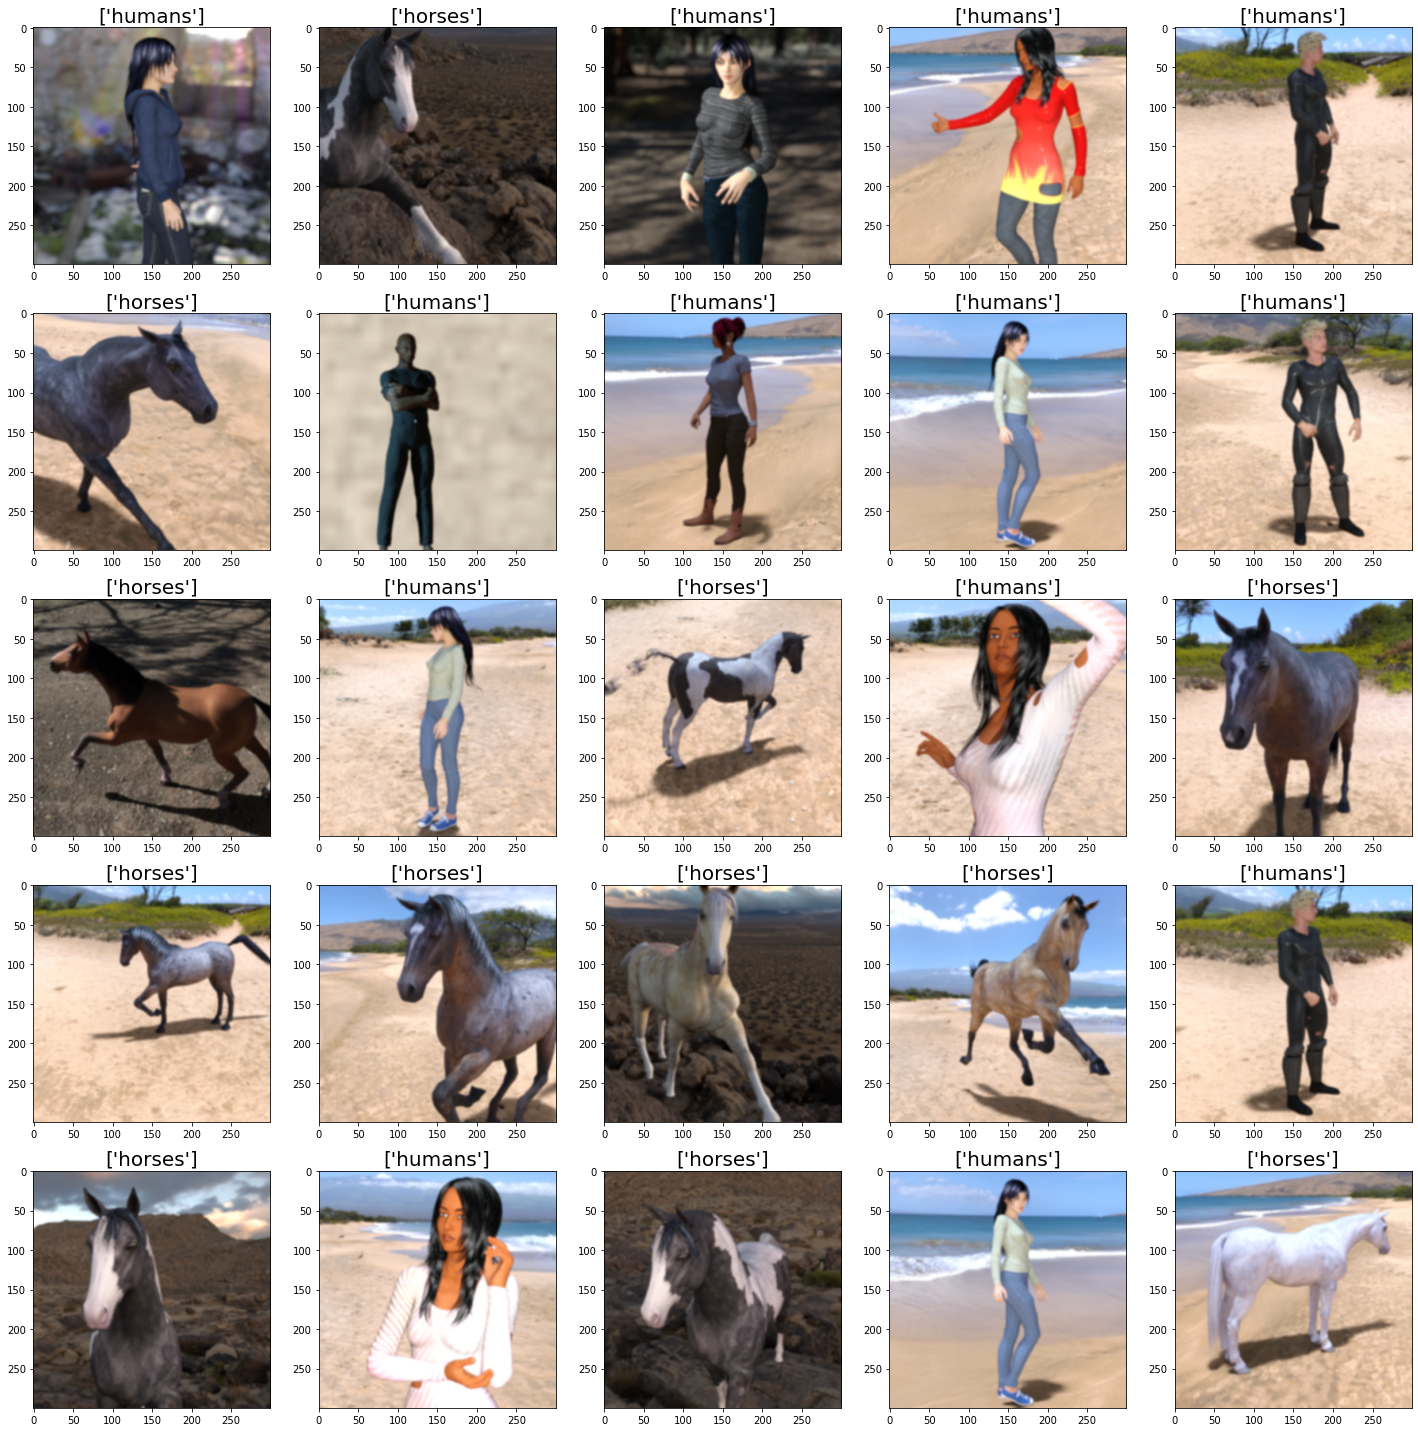

In [14]:
fig,ax=plt.subplots(5,5)
fig.set_size_inches(20,20)
for i in range(5):
    for j in range(5):
        num=np.random.randint(1,len(train_labels))
        ax[i,j].imshow(train_images[num])
        ax[i,j].set_title([train_labels[num]],size =20)
plt.tight_layout()

In [15]:
def preprocess_labels(labels):
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    labels = to_categorical(labels)
    labels = np.array(labels)
    labels = [int(i[0])for i in labels]
    return labels

train_labels_lst = preprocess_labels(train_labels)
valid_labels_lst = preprocess_labels(valid_labels)

# Train Test Split
train_images,test_images,train_labels_lst,test_labels_lst = train_test_split(train_images,train_labels_lst,test_size=0.25,random_state=20)


train_images = train_images / 255.0# Normalize Images
test_images = test_images / 255.0# Normalize Images
valid_images = valid_images / 255.0# Normalize Images
train_images.shape, test_images.shape, valid_images.shape

((770, 300, 300, 3), (257, 300, 300, 3), (256, 300, 300, 3))

In [16]:
batch_size = 32
#tain data augmentation
train_data_aug = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True)

test_datagen = keras.preprocessing.image.ImageDataGenerator()
val_datagen = keras.preprocessing.image.ImageDataGenerator()

train_gen = train_data_aug.flow(train_images, train_labels_lst, batch_size=batch_size)
test_gen = test_datagen.flow(test_images, test_labels_lst, batch_size=batch_size)
valid_gen = val_datagen.flow(valid_images, valid_labels_lst, batch_size=batch_size,  shuffle=False)

In [17]:
cnn_model = keras.models.Sequential()
cnn_model.add(Conv2D(128, (3,3), activation='relu',input_shape=(300,300,3)))
cnn_model.add(MaxPooling2D(3,3))

cnn_model.add(Conv2D(256, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(2,2))

cnn_model.add(Conv2D(256, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(2,2))

cnn_model.add(Conv2D(512, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(2,2))

cnn_model.add(Conv2D(1028, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(2,2))

cnn_model.add(Flatten())
cnn_model.add(BatchNormalization())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.55))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 256)       590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 512)       1

In [18]:
# Compile Model
cnn_model.compile(optimizer=RMSprop(lr=0.00001),loss='binary_crossentropy',metrics=['acc'])

In [19]:

history = cnn_model.fit(train_gen,epochs=5,validation_data=test_gen)

Epoch 1/5
25/25 [==============================] - 25s 629ms/step - loss: 0.6586 - acc: 0.6038 - val_loss: 0.6858 - val_acc: 0.5175
Epoch 2/5
25/25 [==============================] - 16s 642ms/step - loss: 0.5944 - acc: 0.6982 - val_loss: 0.6783 - val_acc: 0.5603
Epoch 3/5
25/25 [==============================] - 16s 622ms/step - loss: 0.5148 - acc: 0.7904 - val_loss: 0.6711 - val_acc: 0.8249
Epoch 4/5
25/25 [==============================] - 16s 644ms/step - loss: 0.4878 - acc: 0.8108 - val_loss: 0.6567 - val_acc: 0.7432
Epoch 5/5
25/25 [==============================] - 16s 624ms/step - loss: 0.4575 - acc: 0.8367 - val_loss: 0.6453 - val_acc: 0.8482


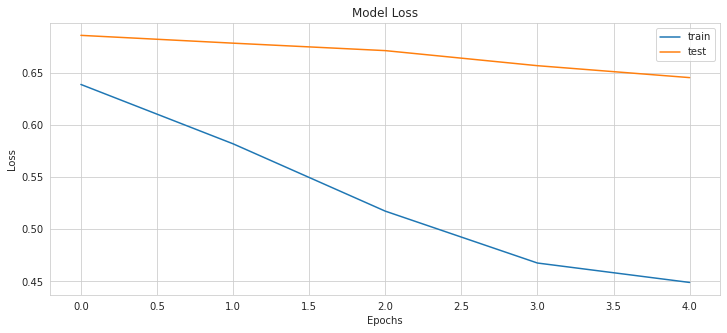

In [20]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

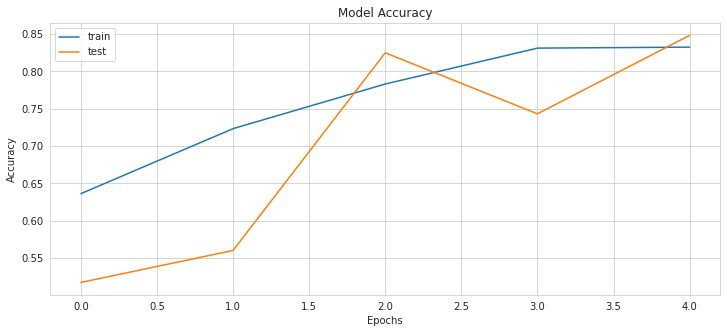

In [21]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [24]:
# Train data evaluation
train_score = cnn_model.evaluate(train_gen)
# Test data evaluation
test_score = cnn_model.evaluate(test_gen)
# Validation data evaluation
valid_score = cnn_model.evaluate(valid_gen)

8/8 [==============================] - 1s 79ms/step - loss: 0.6331 - acc: 0.6406


In [25]:
print("Train_Accuracy = ",train_score[1])
print("Test_Accuracy = ",test_score[1])
print("Validation_Accuracy = ",valid_score[1])

Train_Accuracy =  0.8038961291313171
Test_Accuracy =  0.8482490181922913
Validation_Accuracy =  0.640625
